In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from datetime import timedelta

# Get the current date as a string in the format "YYYY-MM-DD"

# Download historical stock price and additional feature data


imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()

sp500_stocks = pd.read_csv('spx500.csv')
sp500_stocks = sp500_stocks['Symbol'].tolist()
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

['ABEO', 'ABIO', 'ABVC', 'ACB', 'ACHV', 'ACOR', 'ACRX', 'ACST', 'ADIL', 'ADMP', 'AEHL', 'AEMD', 'AEZS', 'AGLE', 'AGRX', 'AHT', 'AIM', 'AIU', 'AKTX', 'ALLK', 'ALPP', 'ALRN', 'AMC', 'AMPE', 'AMSC', 'ANTE', 'ANVS', 'ANY', 'APDN', 'APM', 'APPN', 'APRE', 'APRN', 'APVO', 'AQB', 'ARAV', 'ARCT', 'ASMB', 'ASTC', 'ASXC', 'ATHE', 'ATHX', 'ATNF', 'ATOS', 'ATXI', 'ATXS', 'AUID', 'AUMN', 'AVGR', 'AWH', 'AXDX', 'AYRO', 'AYTU', 'BAND', 'BBIG', 'BBLG', 'BEST', 'BHC', 'BILI', 'BIMI', 'BIOC', 'BIOL', 'BLCM', 'BLIN', 'BLPH', 'BLUE', 'BNGO', 'BNTC', 'BPTH', 'BRQS', 'BRTX', 'BTB', 'BTCM', 'BTCS', 'BTOG', 'BTTR', 'BVXV', 'BXRX', 'BYND', 'CANF', 'CARV', 'CASI', 'CDLX', 'CEAD', 'CEI', 'CELZ', 'CENN', 'CETX', 'CFMS', 'CFRX', 'CGRN', 'CHEK', 'CHGG', 'CJJD', 'CLRB', 'CMMB', 'CMPR', 'CNSP', 'COCP', 'COE', 'COMS', 'CPS', 'CRBP', 'CRDF', 'CREX', 'CRNC', 'CTRM', 'CTRN', 'CUEN', 'CVM', 'CVNA', 'CWBR', 'CYCC', 'CYCN', 'CYTH', 'CYTO', 'DCTH', 'DGLY', 'DOCU', 'DSS', 'DUO', 'DXF', 'EAST', 'EBS', 'ECOR', 'EDSA', 'EDU', 'EF

Helper Functions:

In [ ]:
def get_stock_price(ticker):
    temp_df = yf.download(ticker, start=start_date, end=end_date)
    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def save_weekly_prices(stock_list):
    full_df= pd.DataFrame()
    for t in stock_list:
        t_df = get_stock_price(t)
        if t_df is not None:
            full_df[t] = t_df
    full_df.to_csv('imploded_stock_prices.csv')




## Crash Detection

The method we use for crash detection is to check for (firm-specific) returns that are in the 0.1% of deepest crashes.

In [55]:
def get_firm_specific_returns(weekly_data):
    returns = weekly_data.pct_change()
    return returns
    market_df = get_stock_price('^GSPC') #what market index should i use?
    market_returns = market_df.pct_change()
    market_returns = market_returns.to_frame()
    market_returns.rename(columns={'Adj Close': 'rt-2'}, inplace=True)
    market_returns['rt-1'] = market_returns['rt-2'].shift(1)
    market_returns['rt'] = market_returns['rt-2'].shift(2)
    market_returns['rt+1'] = market_returns['rt-2'].shift(3)
    market_returns['rt+2'] = market_returns['rt-2'].shift(4)
    market_returns['firm_returns'] = returns
    market_returns.dropna(inplace=True)
    market_returns['firm_specific_returns'] = 0
    y_values = []
    X_values = []

    for date, row in market_returns.iterrows():
        y = market_returns.loc[date, 'firm_returns'].reshape(-1, 1) #num of rows unknown  but cols must be 1
        X = market_returns.loc[date, ['rt-2', 'rt-1', 'rt', 'rt+1', 'rt+2']].values.reshape(1, -1)
        y_values.append(y)
        X_values.append(X)

    lr = LinearRegression()
    lr.fit(np.vstack(X_values), np.vstack(y_values))
    y_fits = lr.predict(np.vstack(X_values))
    epsilon = np.vstack(y_values) - y_fits

    for i, date in enumerate(market_returns.index):
        market_returns.loc[date, 'firm_specific_returns'] = np.log(1 + epsilon[i])

    return market_returns['firm_specific_returns']

def get_crash_dates(firm_returns):
    crash_dates = []
    for i in range(len(firm_returns)):
        current_date = firm_returns.index[i]
        current_price = firm_returns.iloc[i]
        prev_year_data = firm_returns[firm_returns.index.year == current_date.year-1]
        mean_price = prev_year_data.mean()
        std_price = prev_year_data.std()
        threshold = mean_price + norm.ppf(0.005)*std_price
        if current_price < threshold:
            crash_dates.append(current_date)
    return crash_dates

def plot_crashes(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        firm_returns = get_firm_specific_returns(stock_series)
        crash_dates = get_crash_dates(firm_returns)
        plt.figure(figsize=(15, 5))
        plt.plot(stock_series.index, stock_series, label=ticker)
        for x1 in crash_dates:
            plt.axvspan(x1, x1, alpha=0.5, color='blue')
        plt.legend()
        plt.show()



Checking the number of imploded stocks that crash

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

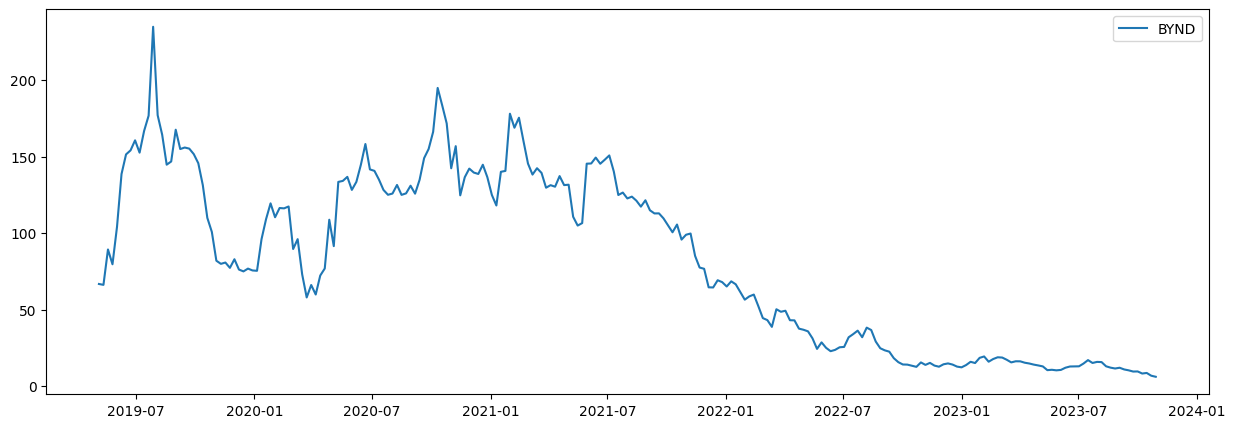

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

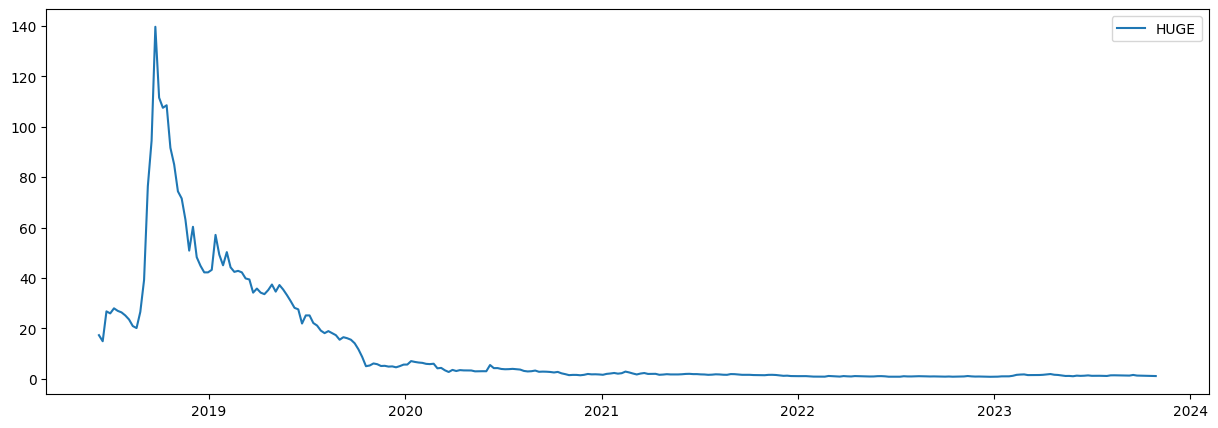

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


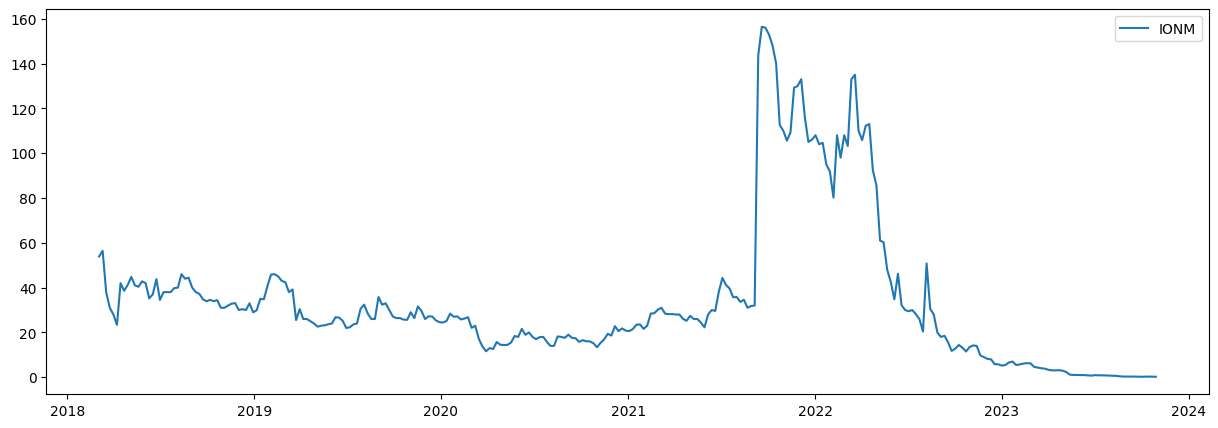

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

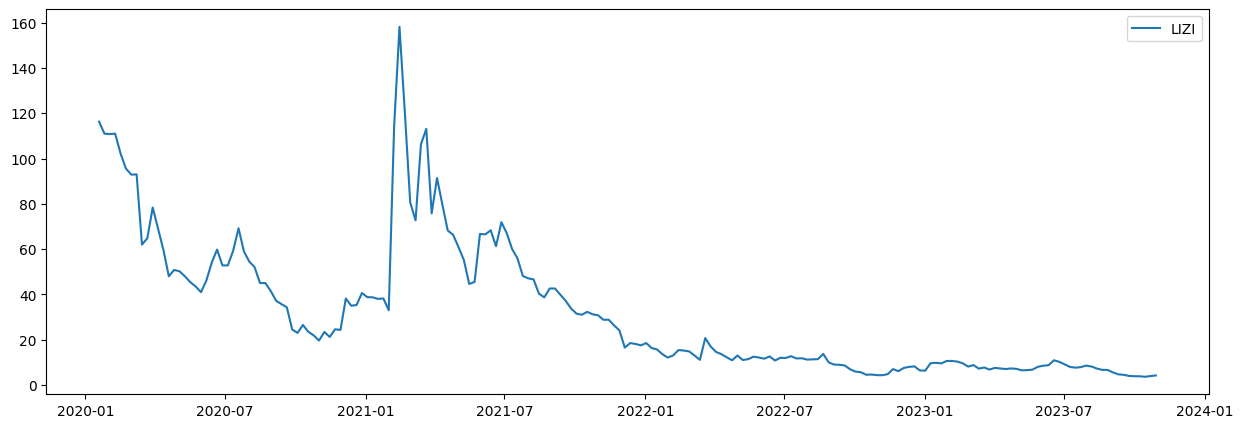

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

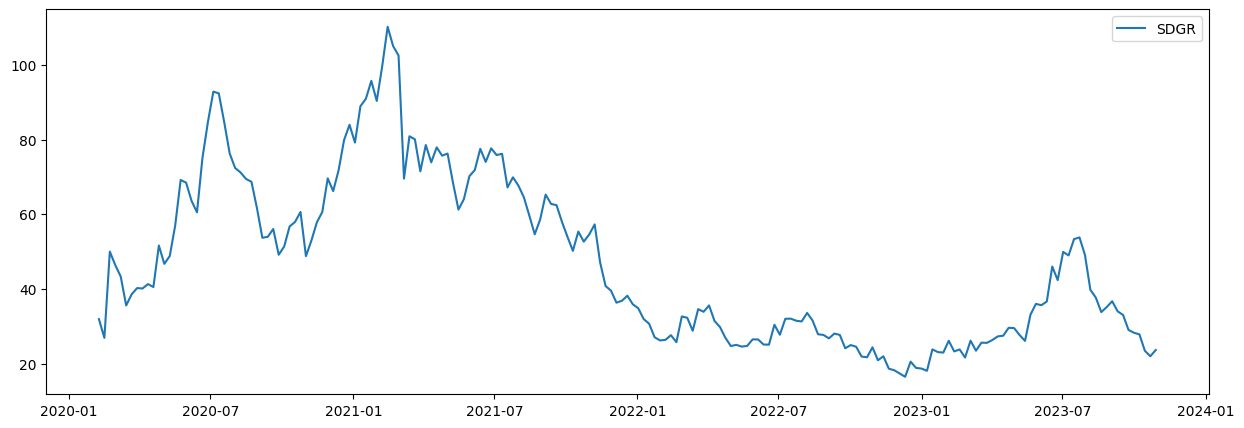

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['YVR']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data available for the specified date range.
[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['YVR']: Exception('%ticker%: No timezone found, symbol may be delisted')



No data available for the specified date range.
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
427 out of 433 experienced crashes


In [56]:
def does_stock_crash(ticker):
    stock_series = get_stock_price(ticker)
    if stock_series is not None:
        firm_returns = get_firm_specific_returns(stock_series)
        crash_dates = get_crash_dates(firm_returns)
        if len(crash_dates) == 0:
            return False
        else:
            return True

num_imp = 0
    
for t in imploded_stocks:
    if does_stock_crash(t):
        num_imp+=1
    else:
        plot_crashes(t)

print(f'{num_imp} out of {len(imploded_stocks)} experienced crashes')


At 0.5% level 427/433 imploded stocks experience crashes using (previous) year mean as threshold

## Implosion Detection

## Testing detection on Imploded Stocks vs S&P500 stocks